In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
def scale_image(image):
    MAX_DIM = 512
    scale = np.max(image.shape)/MAX_DIM
    print(image.shape)
    new_shape = tf.cast(image.shape[:2]/scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    return image

(7444, 4965, 3)
(800, 1280, 3)


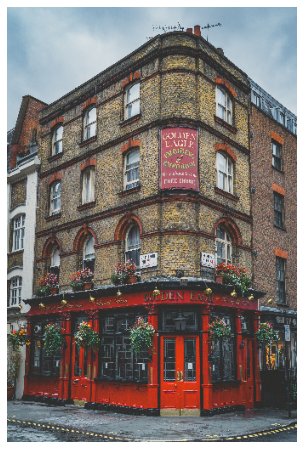

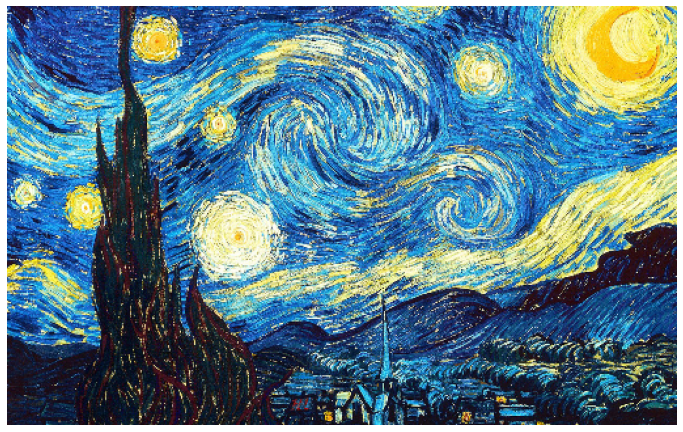

In [31]:
content_image = scale_image(np.asarray(Image.open('images/brown-and-red-concrete-building-3075532.jpg')))
style_image = scale_image(np.asarray(Image.open('images/starry-night-1093721_1280.jpg')))
plt.figure(figsize=(10,8))
plt.imshow(content_image/255.)
plt.axis('off')
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(style_image/255.)
plt.axis('off')
plt.show()

In [44]:
class StyleTransferNetwork:
    def __init__(self, 
                 content_layers=None,
                 style_layers=None):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        default_content_layers = ['block5_conv1']
        default_style_layers = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1', 
                        'block4_conv1', 
                        'block5_conv1']
        content_layers = content_layers if content_layers else default_content_layers
        style_layers = style_layers if style_layers else default_style_layers
        self.content_outputs = [vgg.get_layer(x).output for x in content_layers]
        self.style_outputs = [vgg.get_layer(x).output for x in style_layers]
        self.model = Model(vgg.input, [self.content_outputs, self.style_outputs])

        self.mse = tf.keras.losses.MeanSquaredError()
        
    def gram_matrix(self, x):
        x = tf.transpose(tf.squeeze(x), (2,0,1));
        x = tf.keras.backend.batch_flatten(x)
        num_points = x.shape[-1]
        gram = tf.linalg.matmul(x, tf.transpose(x))/num_points
        return gram

    def extract_features(self, inputs):
        image = tf.keras.applications.vgg19.preprocess_input(inputs*255.)
        contents, styles = self.model(image)
        styles = [self.gram_matrix(s) for s in styles]
        return contents, styles
    
    def calc_loss(self, y_true, y_pred):
        loss = [self.mse(x, y) for x, y in zip(y_pred, y_true)]
        return tf.reduce_mean(loss)
    
    #@tf.function
    def train_step(self, image, content_ref, style_ref):
        with tf.GradientTape() as tape:
            content_features, style_features = self.extract_features(image)
            content_loss = self.content_weight*self.calc_loss(content_ref, content_features)
            style_loss = self.style_weight*self.calc_loss(style_ref, style_features)
            loss = content_loss + style_loss

        grad = tape.gradient(loss, image)
        self.optimizer.apply_gradients([(grad, image)])
        image.assign(tf.clip_by_value(image, 0., 1.))
            
        return content_loss, style_loss    
                
    def train(self, content_image, style_image, steps, content_weight=1, style_weight=1e-5):
        self.style_weight = style_weight
        self.content_weight = content_weight
        
        content_image = tf.reverse(content_image, axis=[-1])
        style_image = tf.reverse(tf.image.resize(style_image, content_image.shape[:2]), axis=[-1])
        
        style_image = tf.cast(tf.expand_dims(style_image, 0), tf.float32)/255.
        content_image = tf.cast(tf.expand_dims(content_image, 0), tf.float32)/255.

        # get reference content and style features
        content_ref, _ = self.extract_features(content_image)
        _, style_ref = self.extract_features(style_image)

        self.optimizer = Adam(0.02,  beta_1=0.99, epsilon=1e-1)
        
        if content_weight==0 or style_weight==0:
            image = tf.Variable(tf.random.normal(shape=content_image.shape))
        else:
            image = tf.Variable(content_image)
        
        for i in range(1,steps+1):
            content_loss, style_loss = self.train_step(image, content_ref, style_ref)
            if i%1000 == 0:
                print(f"Step {i} content_loss {content_loss:.4f} style_loss {style_loss:.4f}")
                plt.figure(figsize=(10,8))
                plt.imshow(tf.reverse(image[0],axis=[-1]))
                plt.axis('off')
                plt.show()
        
        self.stylyzed = tf.cast(255.*tf.reverse(image[0],axis=[-1]), tf.uint8)
        return self.stylyzed


# Reconstruct Content

Step 1000 content_loss 174.5418 style_loss 0.0000


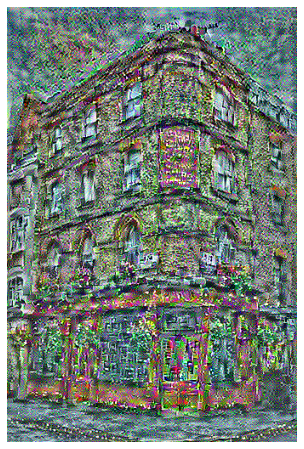

In [46]:
stn = StyleTransferNetwork(content_layers=['block5_conv1'])
image = stn.train(content_image, style_image, steps=1000, content_weight=1, style_weight=0)

# Reconstruct Style

Step 1000 content_loss 0.0000 style_loss 1791.9360


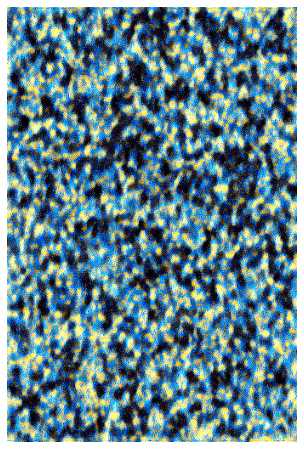

In [47]:
stn = StyleTransferNetwork(style_layers=['block1_conv1'])
image = stn.train(content_image, style_image, steps=1000, content_weight=0, style_weight=1)

#  Style Transfer

Step 1000 content_loss 3009.6509 style_loss 1151.4220


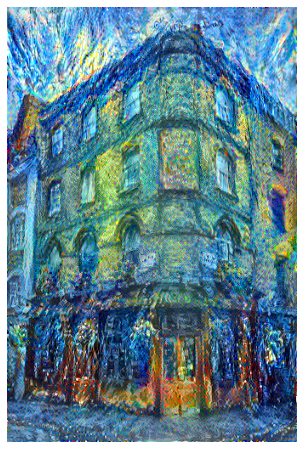

In [48]:
stn = StyleTransferNetwork()
image = stn.train(content_image, style_image, steps=1000, content_weight=1., style_weight=1e-5)